In [1]:
!pip install yfinance

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt



In [2]:

# Parámetros base
ticker = "AAPL"         # ticker
periodo = "1y"          # 1 año de datos
intervalo = "1d"        # datos diarios

datos = yf.download(ticker, period=periodo, interval=intervalo, auto_adjust=False, multi_level_index=False)
datos.tail()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400
2025-11-11,275.250000,275.250000,275.910004,269.799988,269.809998,46208300
2025-11-12,273.470001,273.470001,275.730011,271.700012,275.000000,48398000
2025-11-13,272.950012,272.950012,276.700012,272.089996,274.109985,49602800
2025-11-14,272.410004,272.410004,275.958313,269.600006,271.049988,47348613


#Volatilidad histórica y parámetros del modelo

In [3]:
# Rendimientos logarítmicos diarios
rend = np.log(datos["Close"] / datos["Close"].shift(1)).dropna()

# Volatilidad histórica anualizada
sigma_hist = rend.std() * np.sqrt(252)

# Precio spot actual
S0 = datos["Close"][-1]

# Parámetros del contrato de opción
K = S0 * 1.05        # strike 5% arriba del spot (puedes cambiar)
r = 0.05             # tasa libre de riesgo aproximada
T = 30 / 365         # 30 días hasta el vencimiento
sigma = sigma_hist   # usamos la volatilidad histórica

S0, K, sigma


/tmp/ipython-input-872023043.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = datos["Close"][-1]


(np.float64(272.4100036621094),
 np.float64(286.03050384521487),
 np.float64(0.3231769352626227))

#Árbol binomial (Cox-Ross-Rubinstein)
Funciones para opciones europeas y americanas (call/put)

In [4]:
def binomial_tree_european(S0, K, r, sigma, T, N=100, option_type="call"):
    """
    Valuación de una opción europea (call o put) con un árbol binomial CRR.
    """
    dt = T / N
    # Parámetros CRR
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Precios del subyacente al vencimiento
    ST = np.array([S0 * (u**j) * (d**(N - j)) for j in range(N + 1)])

    # Payoff al vencimiento
    if option_type == "call":
        valores = np.maximum(ST - K, 0.0)
    else:  # put
        valores = np.maximum(K - ST, 0.0)

    # Backward induction
    for i in range(N - 1, -1, -1):
        valores = np.exp(-r * dt) * (p * valores[1:i+2] + (1 - p) * valores[0:i+1])

    return valores[0]


def binomial_tree_american(S0, K, r, sigma, T, N=100, option_type="call"):
    """
    Valuación de una opción americana (call o put) con un árbol binomial CRR,
    permitiendo ejercicio anticipado.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Matriz de precios del subyacente
    ST = np.zeros((N + 1, N + 1))
    ST[0, 0] = S0
    for i in range(1, N + 1):
        ST[i, 0] = ST[i - 1, 0] * d
        for j in range(1, i + 1):
            ST[i, j] = ST[i - 1, j - 1] * u

    # Matriz de valores de la opción
    V = np.zeros_like(ST)

    # Payoff al vencimiento
    if option_type == "call":
        V[N, :] = np.maximum(ST[N, :] - K, 0.0)
    else:
        V[N, :] = np.maximum(K - ST[N, :], 0.0)

    # Backward induction con ejercicio temprano
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = np.exp(-r * dt) * (p * V[i + 1, j + 1] + (1 - p) * V[i + 1, j])
            if option_type == "call":
                exercise = np.maximum(ST[i, j] - K, 0.0)
            else:
                exercise = np.maximum(K - ST[i, j], 0.0)
            V[i, j] = np.maximum(hold, exercise)

    return V[0, 0]


#precio europeo vs americano (call y put)

In [6]:
N = 200  # número de pasos del árbol

precio_call_eur = binomial_tree_european(S0, K, r, sigma, T, N=N, option_type="call")
precio_put_eur  = binomial_tree_european(S0, K, r, sigma, T, N=N, option_type="put")

precio_call_ame = binomial_tree_american(S0, K, r, sigma, T, N=N, option_type="call")
precio_put_ame  = binomial_tree_american(S0, K, r, sigma, T, N=N, option_type="put")

print(f" Call europea (binomial):   {precio_call_eur:.4f}")
print(f" Put  europea (binomial):   {precio_put_eur:.4f}")
print(f" Call americana (binomial): {precio_call_ame:.4f}")
print(f" Put  americana (binomial): {precio_put_ame:.4f}")


 Call europea (binomial):   5.2508
 Put  europea (binomial):   17.6983
 Call americana (binomial): 5.2508
 Put  americana (binomial): 17.8790


(En general, la put americana ≥ put europea; la call americana sin dividendos ≈ call europea.)

#Monte Carlo para opciones europeas (call y put)

Ahora hacemos simulación Monte Carlo usando el mismo
𝑆
0
,
𝑟
,
𝜎
,
𝑇
S
0
	​

,r,σ,T, bajo medida neutral al riesgo:

In [8]:
def monte_carlo_option_european(S0, K, r, sigma, T, n_sim=100_000, option_type="call"):
    """
    Simulación Monte Carlo para opción europea (call o put).
    """
    Z = np.random.randn(n_sim)
    ST = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma * np.sqrt(T) * Z)

    if option_type == "call":
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    precio = np.exp(-r * T) * payoff.mean()
    return precio

precio_call_mc = monte_carlo_option_european(S0, K, r, sigma, T, option_type="call")
precio_put_mc  = monte_carlo_option_european(S0, K, r, sigma, T, option_type="put")

print(f" Call europea (Monte Carlo): {precio_call_mc:.4f}")
print(f" Put  europea (Monte Carlo): {precio_put_mc:.4f}")


 Call europea (Monte Carlo): 5.2673
 Put  europea (Monte Carlo): 17.7071


#Gráfica de convergencia Monte Carlo

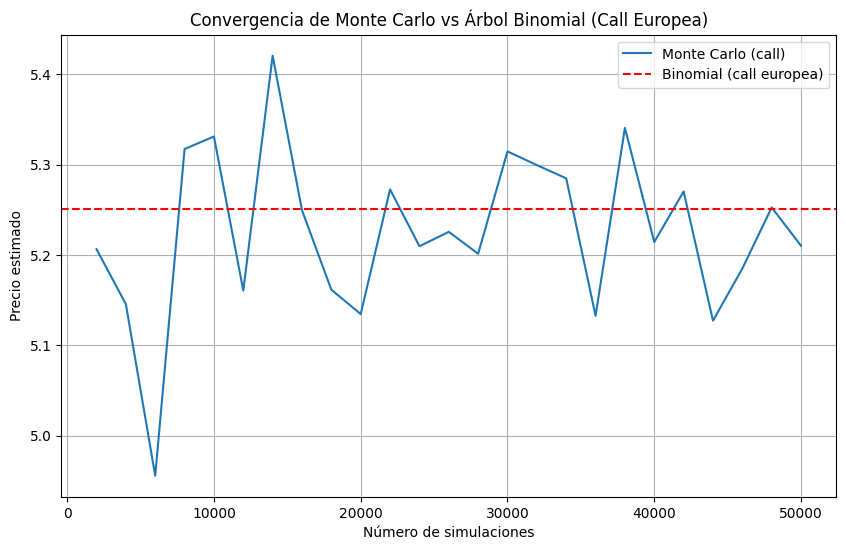

In [10]:
def convergencia_mc(S0, K, r, sigma, T, option_type="call", n_max=50_000, paso=2000):
    ns = np.arange(paso, n_max + 1, paso)
    estimaciones = []

    for n in ns:
        estimaciones.append(monte_carlo_option_european(S0, K, r, sigma, T, n_sim=n, option_type=option_type))

    return ns, np.array(estimaciones)

ns, est_call = convergencia_mc(S0, K, r, sigma, T, option_type="call")

plt.figure(figsize=(10,6))
plt.plot(ns, est_call, label="Monte Carlo (call)")
plt.axhline(precio_call_eur, color="red", linestyle="--", label="Binomial (call europea)")
plt.xlabel("Número de simulaciones")
plt.ylabel("Precio estimado")
plt.title("Convergencia de Monte Carlo vs Árbol Binomial (Call Europea)")
plt.grid(True)
plt.legend()
plt.show()


#Simulación Monte Carlo

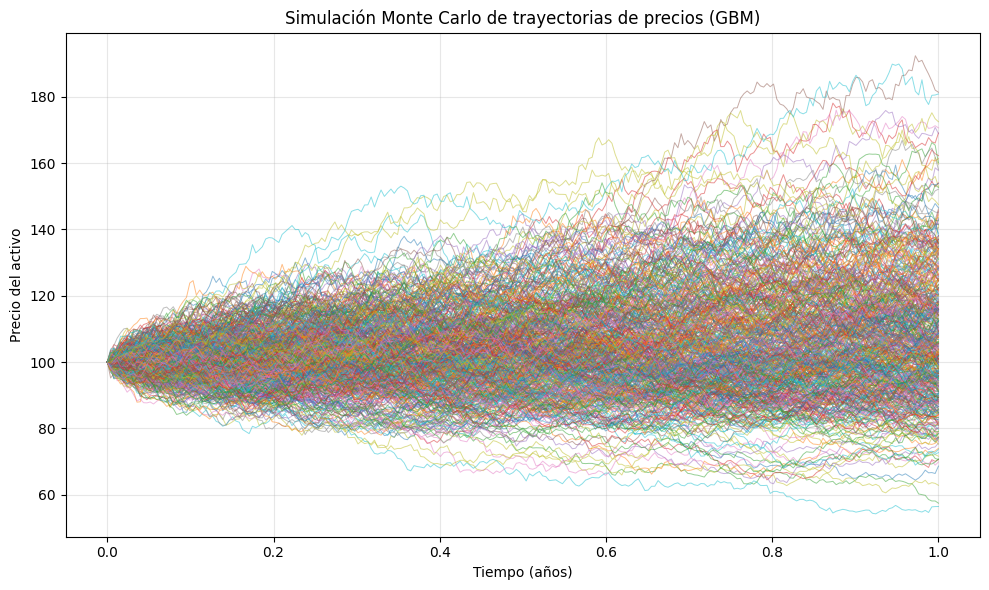

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Parámetros del modelo
# -----------------------
S0 = 100       # precio inicial
mu = 0.08      # rendimiento esperado anual
sigma = 0.2    # volatilidad anual
T = 1.0        # horizonte (1 año)
N = 252        # pasos de tiempo (días)
M = 500        # número de trayectorias (líneas del gráfico)

dt = T / N

# -----------------------
# Simulación Monte Carlo de trayectorias GBM
# -----------------------
# Incrementos brownianos: M x N
dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(M, N))

# Matriz de precios: M trayectorias, N+1 tiempos
S = np.zeros((M, N + 1))
S[:, 0] = S0

for t in range(1, N + 1):
    S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

# Vector de tiempo
tiempo = np.linspace(0, T, N + 1)

# -----------------------
# Gráfico tipo "abanico"
# -----------------------
plt.figure(figsize=(10, 6))

for i in range(M):
    plt.plot(tiempo, S[i, :], linewidth=0.7, alpha=0.5)

plt.title("Simulación Monte Carlo de trayectorias de precios (GBM)")
plt.xlabel("Tiempo (años)")
plt.ylabel("Precio del activo")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Simulación de trayectorias + precios finales
𝑆
𝑇
S
T
	​


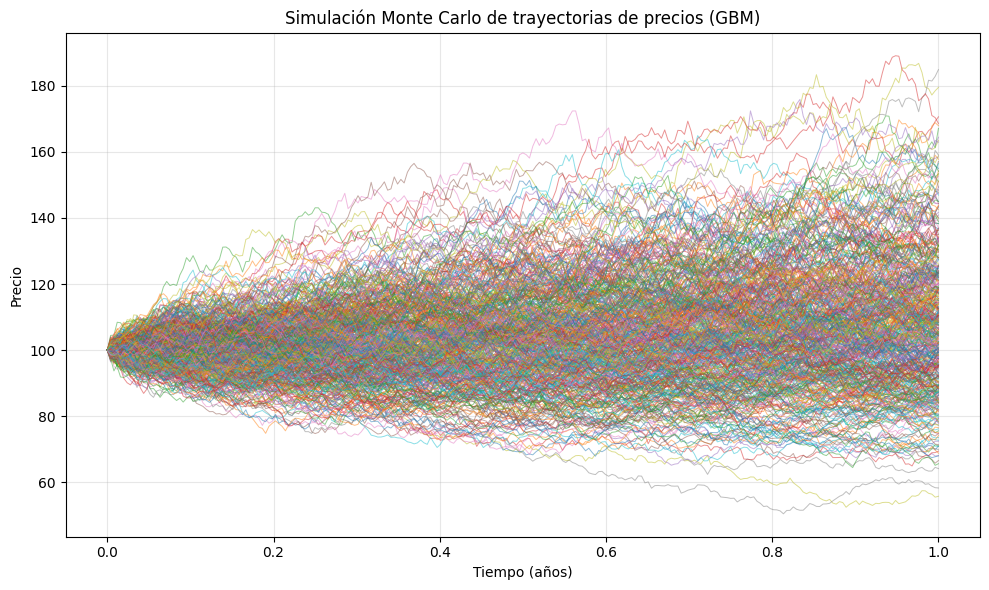

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Semilla para reproducibilidad (opcional)
np.random.seed(42)

# Parámetros del modelo
S0 = 100       # Precio inicial del activo
mu = 0.08      # Rendimiento esperado (mundo real, solo para graficar trayectorias)
sigma = 0.2    # Volatilidad anual
T = 1.0        # 1 año
N = 252        # Pasos (días)
M = 500        # Número de trayectorias para el gráfico

dt = T / N

# Simulación de trayectorias GBM (para visualización)
dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(M, N))
S = np.zeros((M, N + 1))
S[:, 0] = S0

for t in range(1, N + 1):
    S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

tiempo = np.linspace(0, T, N + 1)

plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(tiempo, S[i, :], linewidth=0.7, alpha=0.5)
plt.title("Simulación Monte Carlo de trayectorias de precios (GBM)")
plt.xlabel("Tiempo (años)")
plt.ylabel("Precio")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Monte Carlo para valuar opciones europeas (call y put)

Ahora sí usamos medida neutral al riesgo, es decir, drift =
𝑟
r en lugar de
𝜇
μ.

In [14]:
from scipy.stats import norm

# Parámetros de la opción
K = 110        # Strike
r = 0.05       # Tasa libre de riesgo
T = 1.0        # 1 año
sigma = 0.2    # Volatilidad

# -----------------------------
# 2.1 Función para simular S_T
# -----------------------------
def simular_ST_riesgo_neutral(S0, r, sigma, T, n_sim=100_000):
    Z = np.random.randn(n_sim)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    return ST

# -----------------------------
# 2.2 Precio Monte Carlo (call/put europeas)
# -----------------------------
def precio_mc_opcion_europea(S0, K, r, sigma, T, n_sim=100_000, tipo="call"):
    ST = simular_ST_riesgo_neutral(S0, r, sigma, T, n_sim)
    if tipo == "call":
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    precio = np.exp(-r * T) * payoff.mean()
    return precio

precio_call_mc = precio_mc_opcion_europea(S0, K, r, sigma, T, tipo="call")
precio_put_mc  = precio_mc_opcion_europea(S0, K, r, sigma, T, tipo="put")

print(f" Precio Monte Carlo - Call europea: {precio_call_mc:.4f}")
print(f" Precio Monte Carlo - Put  europea: {precio_put_mc:.4f}")


 Precio Monte Carlo - Call europea: 6.0653
 Precio Monte Carlo - Put  europea: 10.7700


#Comparación con Black-Scholes



In [16]:
def black_scholes_call_put(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call = S0 * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    put  = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    return call, put

precio_call_bsm, precio_put_bsm = black_scholes_call_put(S0, K, r, sigma, T)

print(f" Black-Scholes - Call: {precio_call_bsm:.4f}")
print(f" Black-Scholes - Put : {precio_put_bsm:.4f}")
print("\nDiferencias:")
print(f"Call | MC - BSM = {precio_call_mc - precio_call_bsm:.4f}")
print(f"Put  | MC - BSM = {precio_put_mc  - precio_put_bsm:.4f}")


 Black-Scholes - Call: 6.0401
 Black-Scholes - Put : 10.6753

Diferencias:
Call | MC - BSM = 0.0253
Put  | MC - BSM = 0.0947
